Import Libraries

In [1]:
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt

## Gym Agent and Environment Class

#### Things to Consider 
1. This is limited to drilling interactions, production is not considered in reward
2. SHL is selected by user but should be something we included in the optimization 
3. The action and observations space logic must be preserved for the RL Q-Learning Flow, but the logic is not really dependant on these
4. Collision logic just prevents agents from wrapping around environment on Eastern and Western boundaries. It also prevents from hitting boundaries North and South. Logic just causes a bounce back effect that forces the agent to perform the opposite action ex: if it is going east and hits a boundary, it will go west for that action instead. 
5. Realistically all that can be optimized now is drilling direction based on available drill pipe


All models are created using tiled, here is the download link https://www.mapeditor.org/

location = [row,col]

In [2]:
from wildcatter.environment import SimpleDriller

Create the Env Object

In [3]:
env_config = dict(model_path=r"data/2d_stacked.csv", available_pipe=50, delim=",")

env = SimpleDriller(env_config)

episodes = 1
for episode in range(1, episodes + 1):
    print("Beginning Drill Campaign:", episode)
    state = env.reset()
    done = False
    score = 0

    while not done:
        # env.render()
        action = env.action_space.sample()
        state, reward, done, info = env.step(action)
        score += reward

    print(f"Final Trajectory:{env.trajectory}")
    print("Campaign:{} Score:{}".format(episode, score))
    print("------------------------------------------")

Beginning Drill Campaign: 1
Final Trajectory:[[1, 18], [2, 18], [3, 18], [3, 19], [2, 19], [2, 20], [1, 20], [1, 19]]
Campaign:1 Score:0.0
------------------------------------------


## Actual Execution of Agent/Env Interactions

There are some basic print statements to help users understand what is going on since we don't have a UI or pygame visual to analyze.

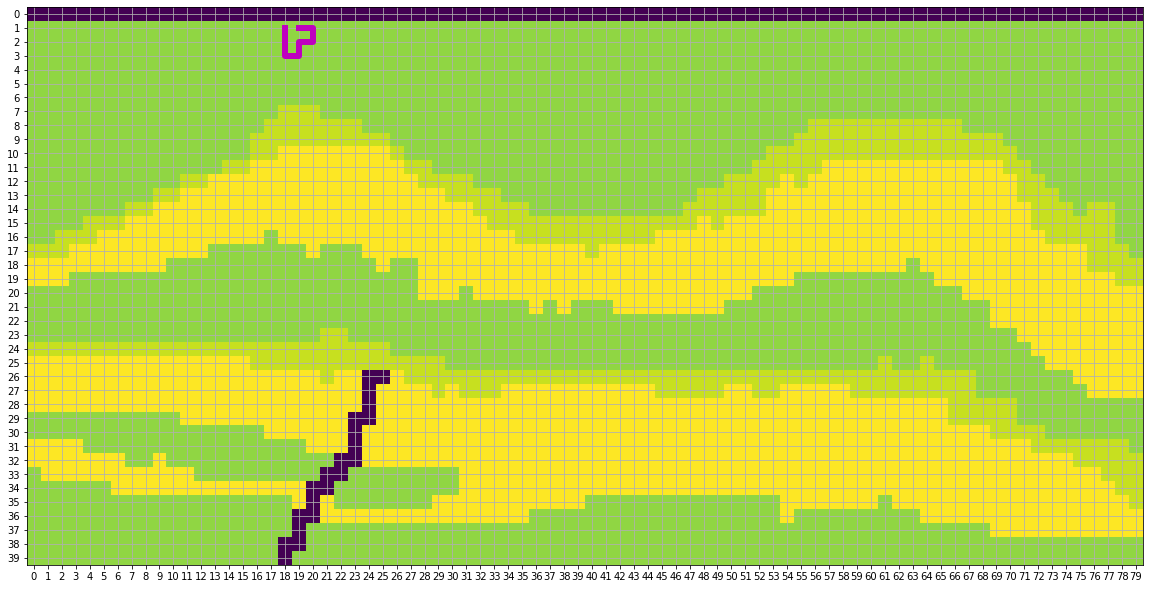

In [4]:
df = pd.DataFrame(env.trajectory, columns=["rows", "colums"])

plt.figure(figsize=(20, 20))
plt.imshow(env.model, vmin=-10, vmax=2)
plt.xticks(np.arange(0, 80, 1.0))
plt.yticks(np.arange(0, 40, 1.0))
plt.grid()
plt.plot(df["colums"], df["rows"], "-", c="m", linewidth=6)

## PPO TESTS

In [5]:
from ray.tune.logger import pretty_print
from ray.rllib.agents.ppo import PPOTrainer
import ray

# Configure the algorithm.
config = {
    "num_workers": 1,
    "framework": "torch",
    "model": {
        "fcnet_hiddens": [64, 64],
        "fcnet_activation": "relu",
    },
    "evaluation_num_workers": 1,
    "evaluation_config": {
        "render_env": False,
    },
}

env_config = {
    "model_path": r"data/2d_stacked.csv",
    "available_pipe": 50,
    "delim": ",",
}

config["env_config"] = env_config

try:
    ray.init()
except RuntimeError:
    ray.shutdown()
    ray.init()

agent = PPOTrainer(config=config, env=SimpleDriller)

for i in range(100):
    # Perform one iteration of training the policy with PPO
    result = agent.train()
    print(pretty_print(result))

    if i % 100 == 0:
        checkpoint = agent.save()
        print("checkpoint saved at", checkpoint)

2022-06-26 22:09:41,083	WARNING trainer.py:2540 -- You have specified 1 evaluation workers, but your `evaluation_interval` is None! Therefore, evaluation will not occur automatically with each call to `Trainer.train()`. Instead, you will have to call `Trainer.evaluate()` manually in order to trigger an evaluation run.
2022-06-26 22:09:41,085	INFO ppo.py:414 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
2022-06-26 22:09:41,085	INFO trainer.py:903 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(RolloutWorker pid=25709) 2022-06-26 22:09:42,274	WARNING env.py:135 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
202

agent_timesteps_total: 4000
counters:
  num_agent_steps_sampled: 4000
  num_agent_steps_trained: 4000
  num_env_steps_sampled: 4000
  num_env_steps_trained: 4000
custom_metrics: {}
date: 2022-06-26_22-09-45
done: false
episode_len_mean: 37.66981132075472
episode_media: {}
episode_reward_max: 91.0
episode_reward_mean: 7.066037735849057
episode_reward_min: 0.0
episodes_this_iter: 106
episodes_total: 106
experiment_id: 049eaa19908543d188202c947a809c98
hostname: Tunas-MBP
info:
  learner:
    default_policy:
      custom_metrics: {}
      learner_stats:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.20000000000000004
        cur_lr: 5.0000000000000016e-05
        entropy: 1.3861144195320785
        entropy_coeff: 0.0
        kl: 0.0001821326983072562
        policy_loss: -0.00512676188141428
        total_loss: 3.3689793202184863
        vf_explained_var: -0.06347525863237279
        vf_loss: 3.374069649883498
      model: {}
      num_agent_steps_trained: 128.0
  num_agent_steps_s

To see tensorboard run this from CLI.

Note Ray needs `grpcio`. On new Macs this has to be installed from conda or be built from scratch for M1 silicon.

The pip version doesn't work, and ray crashes.

```shell
tensorboard --logdir ~/ray_results/
```

In [6]:
# instantiate env class
env = SimpleDriller(env_config)

# run until episode ends
episode_reward = 0
done = False
obs = env.reset()
while not done:
    action = agent.compute_action(obs)
    obs, reward, done, info = env.step(action)
    episode_reward += reward

trajectory = env.trajectory
print(episode_reward)

2022-06-26 22:14:08,886	WARNING deprecation.py:46 -- DeprecationWarning: `compute_action` has been deprecated. Use `Trainer.compute_single_action()` instead. This will raise an error in the future!


68.0


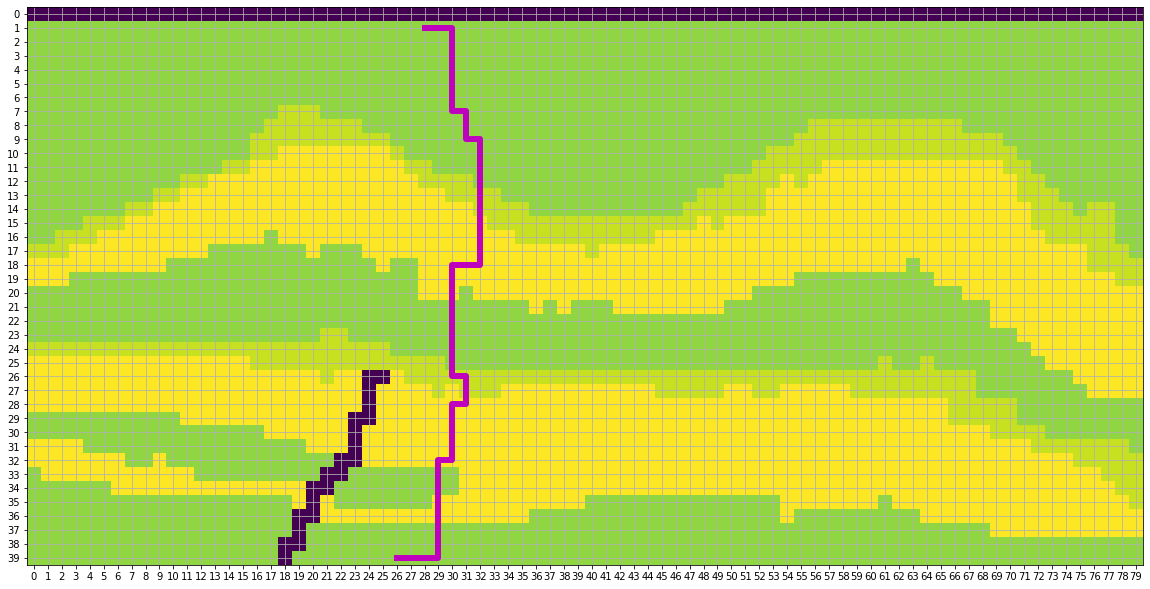

In [7]:
df = pd.DataFrame(env.trajectory, columns=["rows", "colums"])

plt.figure(figsize=(20, 20))
plt.imshow(env.model, vmin=-10, vmax=2)
plt.xticks(np.arange(0, 80, 1.0))
plt.yticks(np.arange(0, 40, 1.0))
plt.grid()
plt.plot(df["colums"], df["rows"], "-", c="m", linewidth=6)

<Figure size 432x288 with 0 Axes>

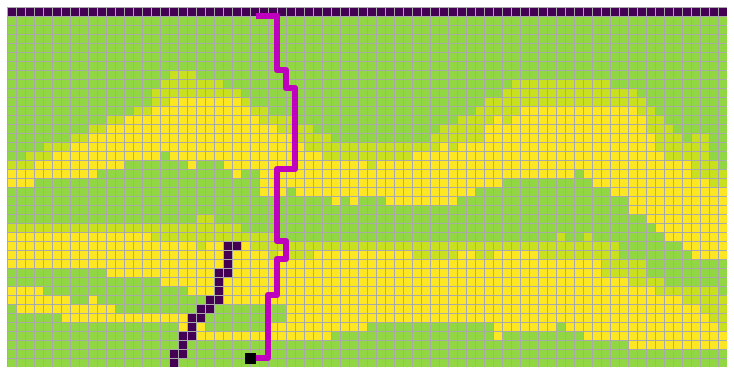

In [8]:
import matplotlib.animation as animation

plt.close("all")

fig = plt.figure(facecolor="white")
fig = plt.figure(figsize=(10, 5))
ax = plt.Axes(fig, [0.0, 0.0, 1.0, 1.0])
ax.set_axis_off()
fig.add_axes(ax)
plt.pcolormesh(
    env.model, vmin=-10, vmax=2, antialiased=True, shading="auto", edgecolors="darkgray"
)
plt.gca().invert_yaxis()

borehole = ax.plot(df["colums"][0], df["rows"][0], ls="-", c="m", lw=6, zorder=10)
bit = ax.scatter(df["colums"][0], df["rows"][0], marker="s", s=100, c="k", zorder=20)


def animate_drill(i):
    borehole[0].set_data(df["colums"][:i], df["rows"][:i])
    bit.set_offsets([df["colums"][i], df["rows"][i]])


anim = animation.FuncAnimation(fig, frames=50, func=animate_drill)

FFwriter = animation.FFMpegWriter(fps=10, bitrate=500)
anim.save("animation.mp4", writer=FFwriter)